In [1]:
import math
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import openpyxl
import cmath
import graphviz
from array import array

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler

In [2]:
# Save an IBM Quantum account and set it as your default account.
API_Token = '13d9540e280b61b7a4254fcdb05516180957df07523dfef1924f7d9363699a51826b42e7a063b3fb685f295f6d27f8ff61810a97f503a704c07bc959d6cc6e3f'
QiskitRuntimeService.save_account(
    channel = "ibm_quantum",
    
    instance ="ibm-q-hub-ntu/ntu-internal/default",
    token = API_Token,
    set_as_default = True,
    # Use `overwrite=True` if you're updating your token.
    overwrite = True,
)

# Load saved credentials
service = QiskitRuntimeService()

#For real Device
#backend = service.least_busy(operational=True, simulator=False)
backend_nazca = service.backend("ibm_kyiv")
noise_model = NoiseModel.from_backend(backend_nazca)

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

#For FakeSimulator
#backend = FakeManilaV2()

# Get coupling map from backend
coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

#For Aer
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
#backend = AerSimulator()
#backend = AerSimulator.from_backend(backend_nazca)

backendqubitNum = backend.num_qubits

#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg_q = QuantumRegister(1, 'q')
creg_c = ClassicalRegister(1, 'c')

InitCirZero = QuantumCircuit(qreg_q, creg_c)

InitCirOne = QuantumCircuit(qreg_q, creg_c)
InitCirOne.x(0)

InitCirPlus = QuantumCircuit(qreg_q, creg_c)
InitCirPlus.h(0)

InitCirRight = QuantumCircuit(qreg_q, creg_c)
InitCirRight.h(0)
InitCirRight.s(0)

# Store the circuits in a dictionary
InitialState = {'Zero': InitCirZero, 'One': InitCirOne, 'Plus': InitCirPlus, 'Right': InitCirRight}

Observable = {'MeasX':Pauli('I' * (backendqubitNum-1) + 'X'), 
              'MeasY':Pauli('I' * (backendqubitNum-1) + 'Y'), 
              'MeasZ':Pauli('I' * (backendqubitNum-1) + 'Z')}
#Observable = {'MeasX':Pauli('X'), 
#              'MeasY':Pauli('Y'), 
#              'MeasZ':Pauli('Z')}

In [3]:
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg_q = QuantumRegister(1, 'q')
creg_c = ClassicalRegister(1, 'c')

MeasCirX = QuantumCircuit(qreg_q, creg_c)
MeasCirX.h(0)

MeasCirY = QuantumCircuit(qreg_q, creg_c)
MeasCirY.sdg(0)
MeasCirY.h(0)

MeasCirZ = QuantumCircuit(qreg_q, creg_c)
# Store the circuits in a dictionary
Measurement = {'Xmeas': MeasCirX, 'Ymeas': MeasCirY, 'Zmeas': MeasCirZ}

Circuit = {}
for InitName, Initial in InitialState.items():
    for MeasName, Measure in Measurement.items():
        circuit = q.circuit.QuantumCircuit.compose(Initial, Measure)
        circuit.measure_all()
        Circuit.update({f'{InitName}_{MeasName}':circuit})

In [4]:
shots = 10000
sampler = Sampler(mode=backend)

job = {}
for Name, Cir in Circuit.items():
    #pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
    job.update({Name:sampler.run([CirTran], shots=shots)})

In [5]:
#for sampler
result = []
for index, job_name in job.items():
    res = job_name.result()
    result.append(res[0].data.meas.get_counts())
result

[{'1': 5045, '0': 4955},
 {'1': 4927, '0': 5073},
 {'0': 9929, '1': 71},
 {'0': 4987, '1': 5013},
 {'1': 5028, '0': 4972},
 {'1': 9914, '0': 86},
 {'0': 9905, '1': 95},
 {'1': 4978, '0': 5022},
 {'0': 5033, '1': 4967},
 {'0': 4957, '1': 5043},
 {'0': 9894, '1': 106},
 {'0': 5023, '1': 4977}]

In [6]:
#Create GramMatrix g
g = np.ones((4, 4))
row = 1
column = 0
for i in range (len(result)):
    sum_zero = 0
    for k ,v in result[i].items() :
        if k[0] == '0':
            sum_zero += v
    zero = 2*(int(sum_zero)/10000) - 1
    
    if row == 4:
        row = 1
        column += 1
    g[row][column] = zero
    row += 1

print(g)

[[ 1.      1.      1.      1.    ]
 [-0.009  -0.0026  0.981  -0.0086]
 [ 0.0146 -0.0056  0.0044  0.9788]
 [ 0.9858 -0.9828  0.0066  0.0046]]


In [7]:
#Create GramMatrix g
g = np.ones((4, 4))
row = 1
column = 0
for i in range (len(result)):
    sum_zero = 0
    for k ,v in result[i].items() :
        if k[0] == '0':
            sum_zero += v
    zero = 2*(int(sum_zero)/10000) - 1
    
    if row == 4:
        row = 1
        column += 1
    g[row][column] = zero
    row += 1

print(g)

#Create State Preparation Matrix A
A = np.array([[1, 1, 1, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1,-1, 0, 0]])

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
print(A_inv)
B = np.matmul(g, A_inv)
print(B)

#Calculate observable X, Y, Z
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])

B_inv = inv(B)
q_x = np.matmul(a_x, B_inv)
q_y = np.matmul(a_y, B_inv)
q_z = np.matmul(a_z, B_inv)
print(B_inv, '\n\n', q_x, '\n\n', q_y, '\n\n', q_z)

[[ 1.      1.      1.      1.    ]
 [-0.009  -0.0026  0.981  -0.0086]
 [ 0.0146 -0.0056  0.0044  0.9788]
 [ 0.9858 -0.9828  0.0066  0.0046]]
[[ 0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5 -0.5]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]]
[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-5.800e-03  9.868e-01 -2.800e-03 -3.200e-03]
 [ 4.500e-03 -1.000e-04  9.743e-01  1.010e-02]
 [ 1.500e-03  5.100e-03  3.100e-03  9.843e-01]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.85953251e-03  1.01335999e+00  2.90186535e-03  3.26469891e-03]
 [-4.60213707e-03  1.58443801e-04  1.02641188e+00 -1.05315990e-02]
 [-1.53979172e-03 -5.25106892e-03 -3.24766467e-03  1.01596667e+00]] 

 [[0.00585953 1.01335999 0.00290187 0.0032647 ]] 

 [[-4.60213707e-03  1.58443801e-04  1.02641188e+00 -1.05315990e-02]] 

 [[-0.00153979 -0.00525107 -0.00324766  1.01596667]]


In [16]:
q_reg = QuantumRegister(1, 'q')
c_reg = ClassicalRegister(1, 'c')

testCir = QuantumCircuit(q_reg, c_reg)
testCir.h(0)
testCir.ry(-np.pi/8, 0)

ErrorObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Z')], coeffs=[-1/np.sqrt(2), 1/np.sqrt(2)])
IdealObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'I'), ('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Y'), ('I' * (backendqubitNum-1) + 'Z')], 
                                coeffs=[(-q_x[0][0]+q_z[0][0])/np.sqrt(2), (-q_x[0][1]+q_z[0][1])/np.sqrt(2), (-q_x[0][2]+q_z[0][2])/np.sqrt(2), (-q_x[0][3]+q_z[0][3])/np.sqrt(2)])

In [17]:
estimator = Estimator(mode=backend)

ErrorExpectation = []
for i in range (50):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    job = estimator.run([(CirTran, ErrorObservable)])
    result = job.result()
    ErrorExpectation.append(result[0].data.evs)
    #print(f'Expectation_{i + 1}:', result[0].data.evs)

In [18]:
IdealExpectation = []
for i in range (50):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    job = estimator.run([(CirTran, IdealObservable)])
    result = job.result()
    IdealExpectation.append(result[0].data.evs)
    #print(f'Expectation_{i + 1}:', result[0].data.evs)

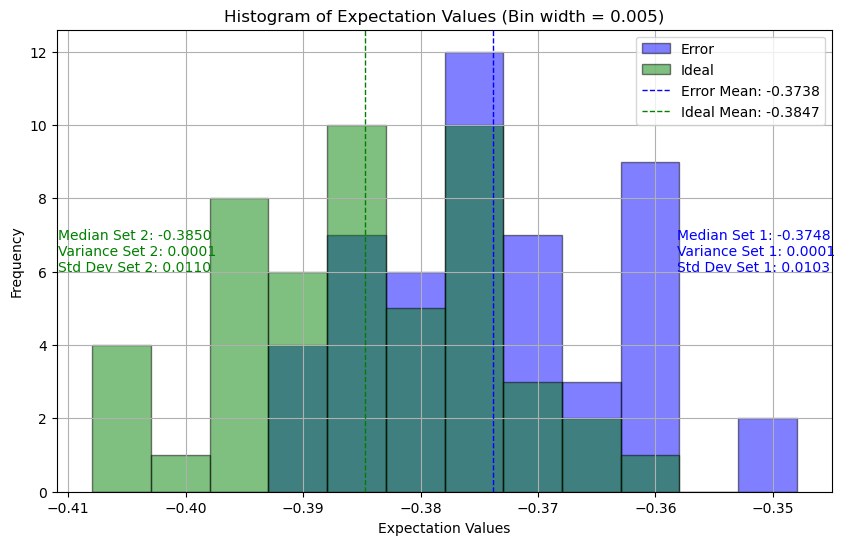

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# 假設已經有 ErrorExpectation 和 IdealExpectation 的數據
# ErrorExpectation 和 IdealExpectation 是一維 numpy array

# 設定參數
bin_width = 0.005  # bin 的寬度
bins = np.arange(min(min(ErrorExpectation), min(IdealExpectation)),
                 max(max(ErrorExpectation), max(IdealExpectation)) + bin_width, bin_width)

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(ErrorExpectation, bins=bins, alpha=0.5, label='Error', color='blue', edgecolor='black')
plt.hist(IdealExpectation, bins=bins, alpha=0.5, label='Ideal', color='green', edgecolor='black')

# 計算統計數據
mean_set1 = np.mean(ErrorExpectation)
median_set1 = np.median(ErrorExpectation)
std_dev_set1 = np.std(ErrorExpectation)

mean_set2 = np.mean(IdealExpectation)
median_set2 = np.median(IdealExpectation)
std_dev_set2 = np.std(IdealExpectation)

# 添加統計線
plt.axvline(mean_set1, color='blue', linestyle='dashed', linewidth=1, label=f'Error Mean: {mean_set1:.4f}')
plt.axvline(mean_set2, color='green', linestyle='dashed', linewidth=1, label=f'Ideal Mean: {mean_set2:.4f}')

# 添加標籤、圖例和標題
plt.xlabel('Expectation Values')
plt.ylabel('Frequency')
plt.title('Histogram of Expectation Values (Bin width = 0.005)')
plt.legend(loc='upper right', fontsize=10)

# 添加統計數據注解
plt.text(max(ErrorExpectation)-0.0091,6,  # 調整位置以適合數據範圍
         f'Median Set 1: {median_set1:.4f}\nVariance Set 1: {np.var(ErrorExpectation):.4f}\nStd Dev Set 1: {std_dev_set1:.4f}',
         color='blue', fontsize=10)

plt.text(min(IdealExpectation)-0.0029,6,
         f'Median Set 2: {median_set2:.4f}\nVariance Set 2: {np.var(IdealExpectation):.4f}\nStd Dev Set 2: {std_dev_set2:.4f}',
         color='green', fontsize=10)

# 顯示網格
plt.grid(True)
plt.show()